Fashion MNIST Classification with Supervised Learning

En este proyecto veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican las observaciones y con cuales obtenemos mayor rendimiento. 

1. [Exploración de algoritmos supervisados](#eje1) \
    1.1. [Carga de datos](#eje10) \
    1.2. [Naive-Bayes](#eje11) \
    1.3. [Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)](#eje12) \
    1.4. [K vecinos más próximos (KNN)](#eje13) \
    1.5. [Máquinas de soporte vectorial (SVM)](#eje14) \
    1.6. [Árboles de decisión](#eje15) 


In [25]:
import os
import shap
import copy
import tqdm
import torch
import pickle
import kagglehub
import umap

import seaborn as sns
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from matplotlib.colors import ListedColormap

from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split
from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc

%matplotlib inline

<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.1. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [3]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
X = data["images"]
y = data["labels"]
n_classes = 5
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Vector Image Dimensions: {}".format(X.shape))
print("Vector Label Dimensions: {}".format(y.shape))

Vector Image Dimensions: (5000, 784)
Vector Label Dimensions: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

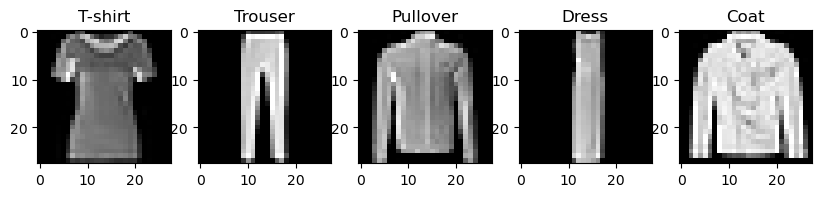

In [4]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(y == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(X[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels[i]))

plt.show()

In [5]:
# División del dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

print("Dimensiones de X_train: {}".format(X_train.shape))
print("Dimensiones de X_test: {}".format(X_test.shape))
print("Dimensiones de y_train: {}".format(y_train.shape))
print("Dimensiones de y_test: {}".format(y_test.shape))


Dimensiones de X_train: (4000, 784)
Dimensiones de X_test: (1000, 784)
Dimensiones de y_train: (4000,)
Dimensiones de y_test: (1000,)


 Con las dimensiones podemos observar que se han creado correctamente los conjuntos de entrenamiento y de test


Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

c:\Users\Rebeca\anaconda3\envs\uoc20241pec3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


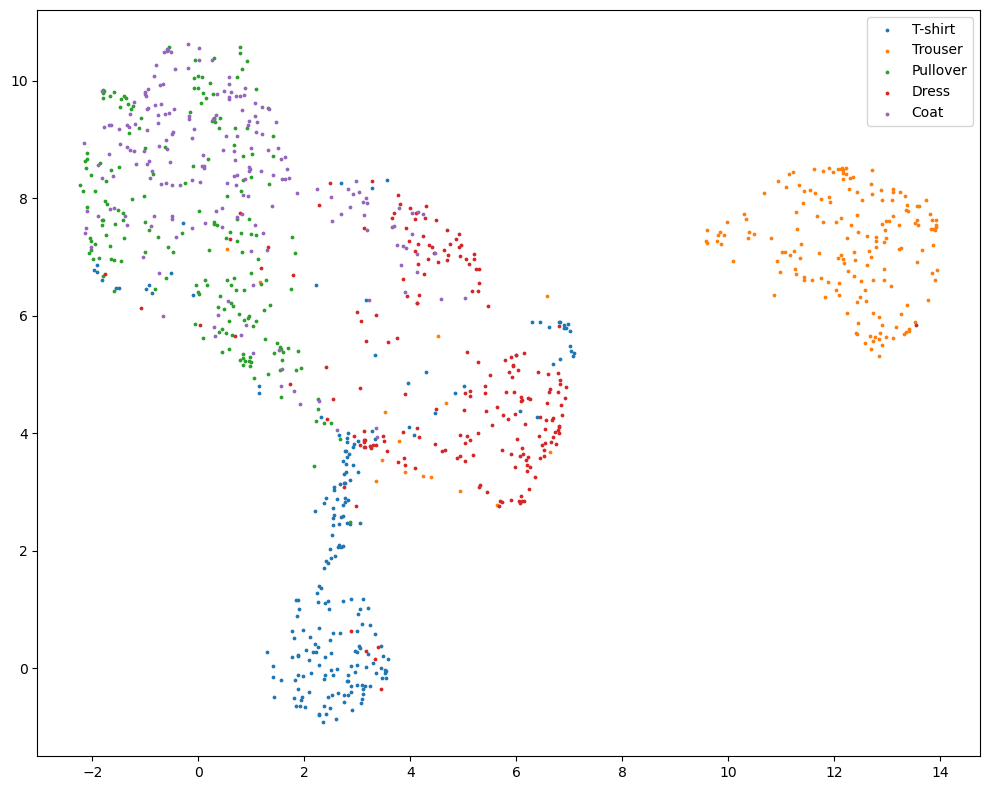

In [6]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=labels[i])
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Create the meshgrid with the minimum and maximum values of the x and y axes
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

# Define the function that will visualize the decision boundary
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # Prediction by using all values of the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Define the colors (one for each class)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred']
    
    # Draw the borders
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Draw the points
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

<a id='ej11'></a>
## 1.2. Gaussian Naïve Bayes 


Train accuracy: 0.75
Test accuracy: 0.73
Matriz de Confusión:


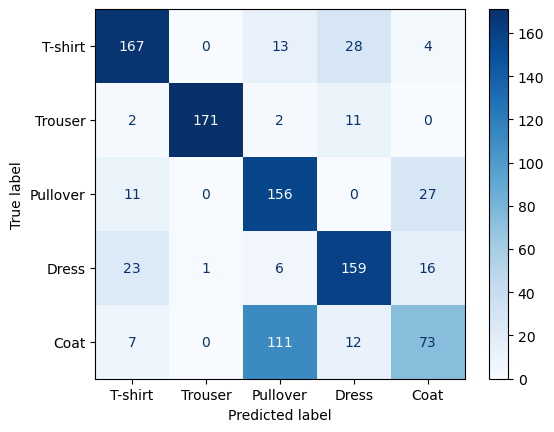

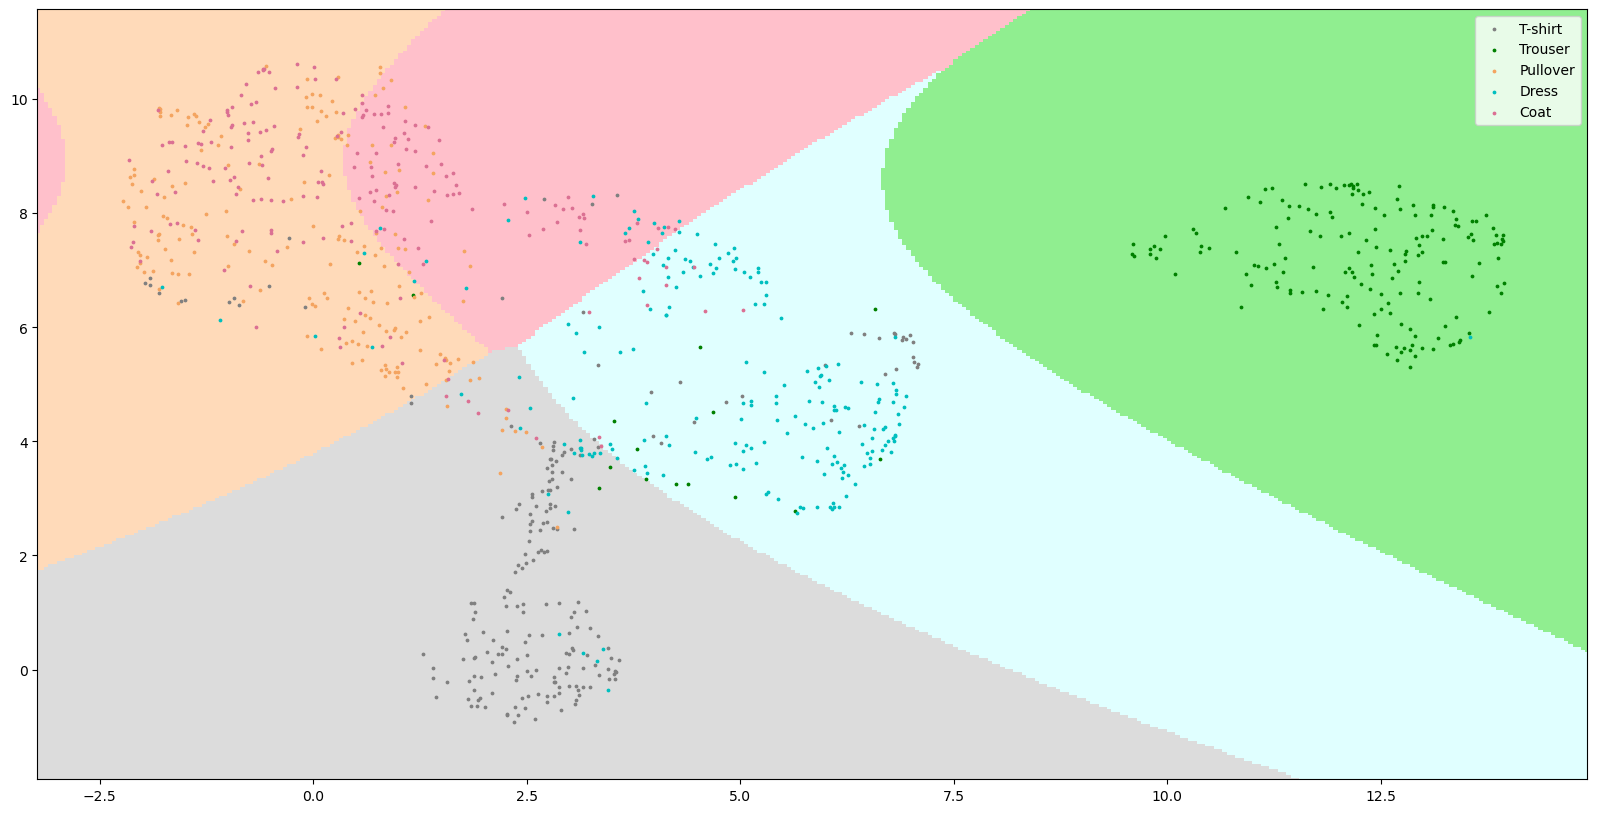

In [14]:
# 1. Entrenamiento del Modelo Gaussian Naïve Bayes
gnb = GaussianNB()
gnb.fit(X_train_projection, y_train)

# 2. Cálculo del Accuracy
y_train_pred = gnb.predict(X_train_projection)
y_test_pred = gnb.predict(X_test_projection)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Representación Gráfica de la Frontera de Decisión
plot_decision_boundaries(gnb, X_test_projection, y_test)


<div class="alert alert-block alert-success">

- Las fronteras de decisión generadas por el clasificador de bayes son curvas suaves y no lineales. Esto tiene sentido ya que el modelo asume que las características tienen una distribución gaussiana (normal) independiente para cada clase.

- El conjunto de test obtuvo una precisión moderada de 75% lo que significa que está logrando ajustar correctamente la mayoría de las observaciones de los datos con los que fue entrenado. Con el conjunto de entrenamiento la precisión disminuye ligeramente (73%) lo cual es esperable. Esta caída del 2% nos indica que no hay sobreajuste significativo.  
Respecto a la matriz de confusión, la clase con mejor desempeño fue la de Trouser con 171 predicciones correctas y muy pocos errores (15). Podemos ver que en la frontera de decisión esta bien separada y es facil de identificar. Por otro lado, las clases con mas similitudes visuales como Coat (111 imagenes clasificadas erroneamentes como Pullover) presentan mayores errores. 
</div>

<a id='ej12'></a>
## 1.3 Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrático (QDA) 

Train accuracy (LDA): 0.76
Test accuracy (LDA): 0.74
Matriz de Confusión (LDA):


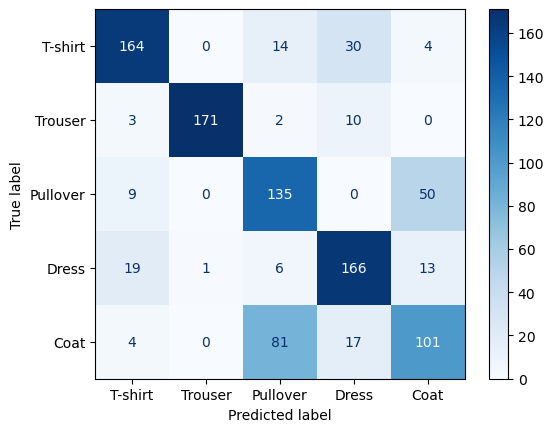

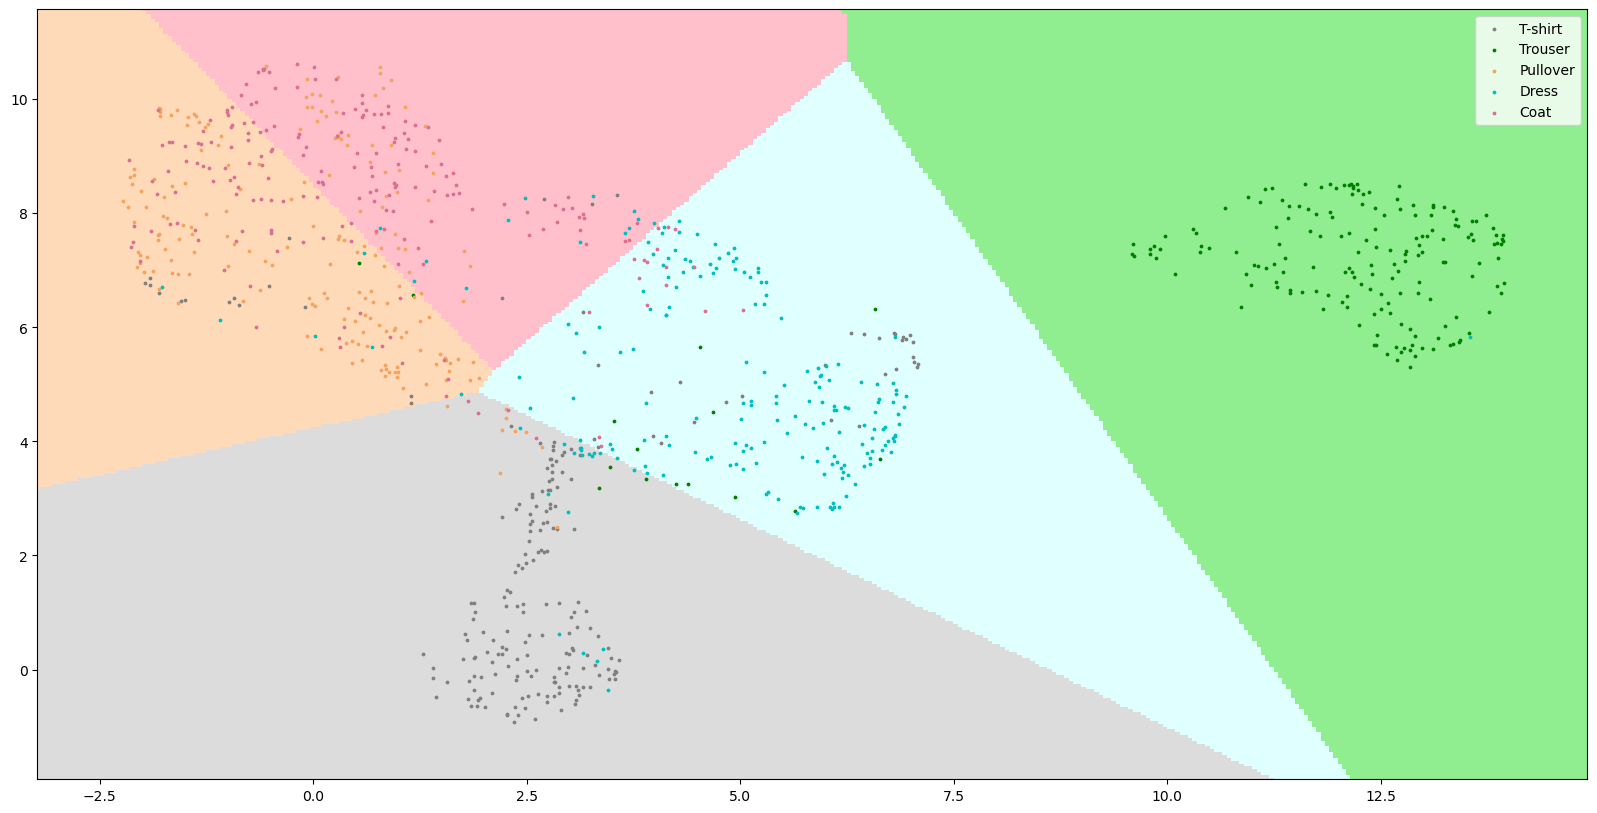

In [15]:
# 1. Entrenamiento del modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_projection, y_train)

# 2. Cálculo de accuracy
y_train_pred_lda = lda.predict(X_train_projection)
y_test_pred_lda = lda.predict(X_test_projection)

train_accuracy_lda = accuracy_score(y_train, y_train_pred_lda)
test_accuracy_lda = accuracy_score(y_test, y_test_pred_lda)

print("Train accuracy (LDA): {:.2f}".format(train_accuracy_lda))
print("Test accuracy (LDA): {:.2f}".format(test_accuracy_lda))

# 3. Matriz de confusión
cm_lda = confusion_matrix(y_test, y_test_pred_lda)
print("Matriz de Confusión (LDA):")
disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=labels)
disp_lda.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Frontera de decisión
plot_decision_boundaries(lda, X_test_projection, y_test)


<div class="alert alert-block alert-success">

- Las fronteras de decisión generadas son rectas y lineales, lo cual es coherente con la naturaleza del algoritmo LDA el cual asume que las clases tienen distribuciones gaussianas con iguales varianzas, lo que produce fronteras lineales entre las clases. Cada clase define una región separada por líneas rectas, donde las probabilidades condicionales de pertenencia son mayores que las de las demás clases.

- La precisión en train y test es similar, lo que indica que el modelo no está sobreajustando y generaliza razonablemente bien. Sin embargo los resultados siguen siendo limitados principalmente debido a las confusiones entre clases similares, esto se ve reflejado en la matriz de confusión al igual que en el modelo anterior, entre "Pullover" y Coat" aunque se produjo una ligera mejora frente a los resultados anteriores. 
Las clases claramente separadas como "Trouser" tienen una alta precisión, mientras que las que se solapan como "Pullover" y "Coat" tienen mas errores de clasificación. 



</div>

Train accuracy (QDA): 0.74
Test accuracy (QDA): 0.72
Matriz de Confusión (QDA):


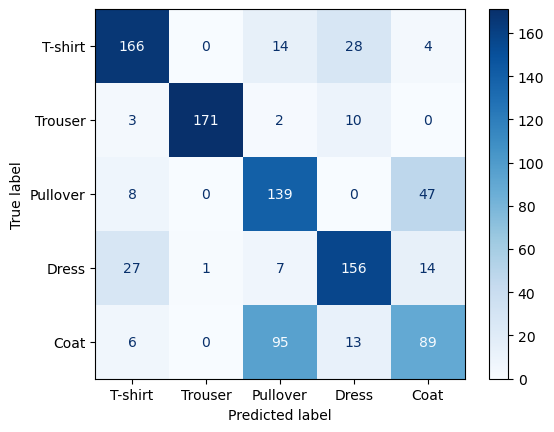

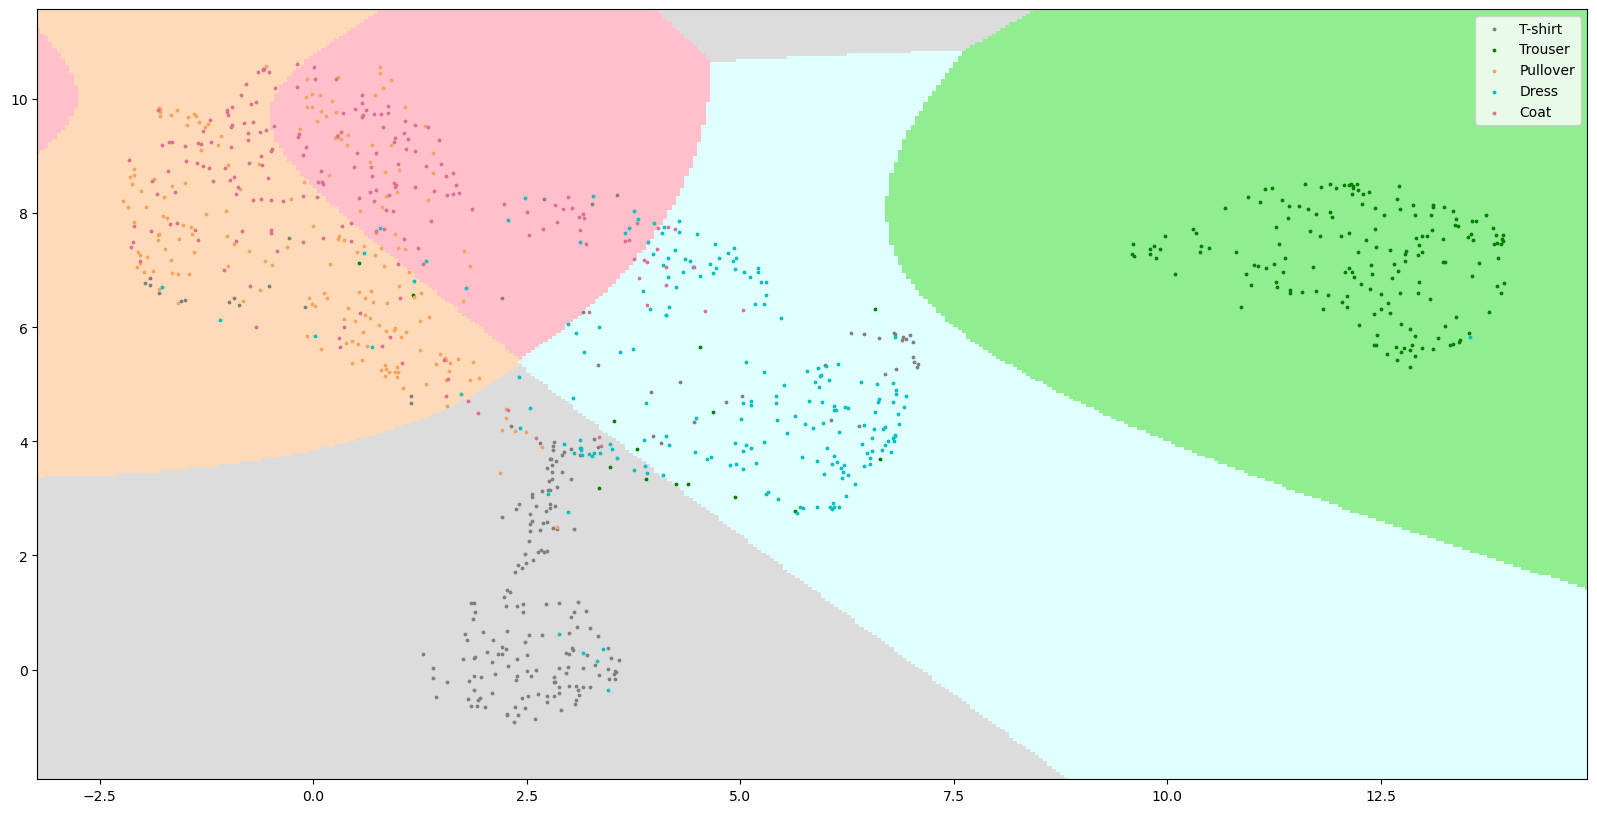

In [16]:
# 1. Entrenamiento del modelo QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_projection, y_train)

# 2. Cálculo de accuracy
y_train_pred_qda = qda.predict(X_train_projection)
y_test_pred_qda = qda.predict(X_test_projection)

train_accuracy_qda = accuracy_score(y_train, y_train_pred_qda)
test_accuracy_qda = accuracy_score(y_test, y_test_pred_qda)

print("Train accuracy (QDA): {:.2f}".format(train_accuracy_qda))
print("Test accuracy (QDA): {:.2f}".format(test_accuracy_qda))

# 3. Matriz de confusión
cm_qda = confusion_matrix(y_test, y_test_pred_qda)
print("Matriz de Confusión (QDA):")
disp_qda = ConfusionMatrixDisplay(confusion_matrix=cm_qda, display_labels=labels)
disp_qda.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Frontera de decisión
plot_decision_boundaries(qda, X_test_projection, y_test)

<div class="alert alert-block alert-success">

- Las fronteras de decisión generadas por el modelo QDA tienen una forma no lineal, lo cual es coherente con la naturaleza del algoritmo. QDA permite que cada clase tenga su propia matriz de covarianza, lo que resulta en fronteras curvas y más flexibles en comparación con las fronteras lineales de LDA.

- La precisión en train y test es similar y ligeramente inferior a la obtenida por LDA. A pesar de que QDA tiene mayor flexibilidad, en este caso no logra una mejora significativa porque las clases "Pullover" y "Coat" aún presentan un solapamiento considerable. Los errores más significativos siguen ocurriendo entre las clases "Pullover" y "Coat"

- Mientras que LDA asume que las clases tienen distribuciones gaussianas con iguales matrices de covarianza (lo que resulta en fronteras lineales entre las clases), QDA permite que cada clase tenga su propia matriz de covarianza (generando fronteras no lineales y más flexibles).
En términos de resultados, LDA mostró un rendimiento ligeramente superior (train: 0.76, test: 0.74) comparado con QDA (train: 0.74, test: 0.72), lo que sugiere que, aunque QDA es más flexible, esta mayor complejidad no necesariamente mejora el rendimiento cuando existe solapamiento significativo entre clases, como ocurre entre "Pullover" y "Coat".

</div>

<a id='ej13'></a>
## 1.4. KNN 

KNN es un algoritmo de tipo supervisado basado en instancia. Esto significa:

- Supervisado: Tu conjunto de datos de entrenamiento está etiquetado con la clase o resultado esperado.
- Basado en instancia (_Lazy Learning_): El algoritmo no aprende explícitamente un modelo, como en la Regresión Logística o los árboles de decisión. En cambio, memoriza las instancias de entrenamiento y las utiliza como "conocimiento" en la fase de predicción.



Train accuracy (KNN, k=2): 0.88
Test accuracy (KNN, k=2): 0.73
Matriz de Confusión (KNN, k=2):


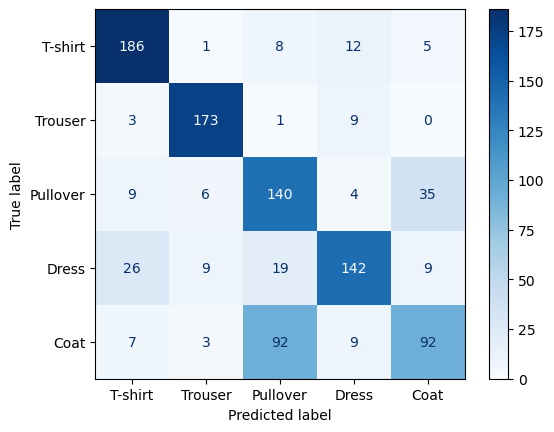

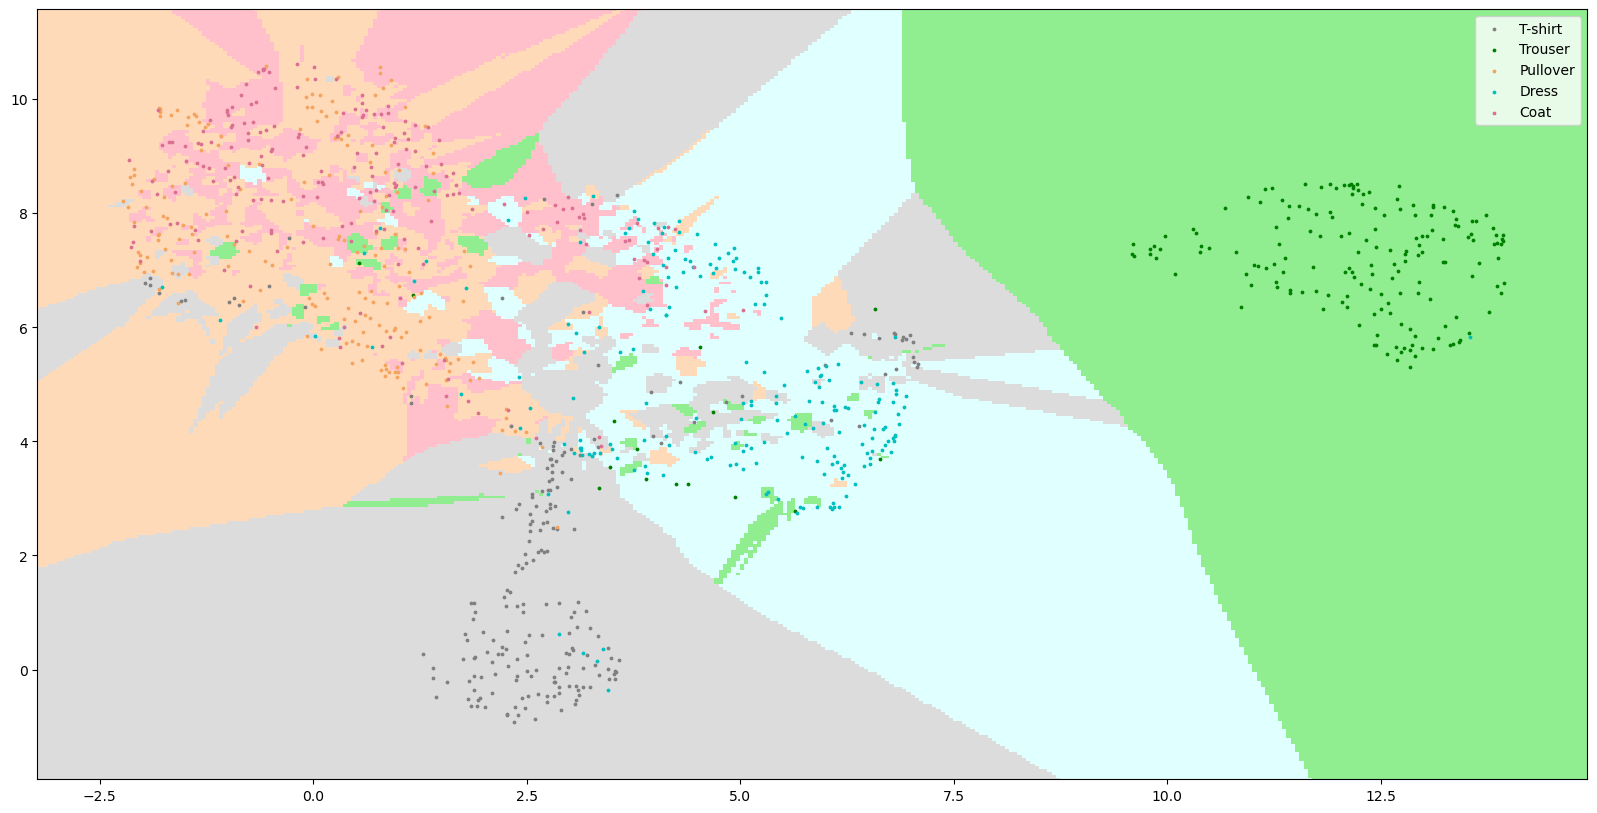

In [17]:
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

# 1. Entrenamiento del modelo KNN con n_neighbors=2
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_projection, y_train)

# 2. Cálculo del accuracy
y_train_pred_knn = knn.predict(X_train_projection)
y_test_pred_knn = knn.predict(X_test_projection)

train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

print("Train accuracy (KNN, k=2): {:.2f}".format(train_accuracy_knn))
print("Test accuracy (KNN, k=2): {:.2f}".format(test_accuracy_knn))

# 3. Matriz de confusión
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
print("Matriz de Confusión (KNN, k=2):")
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=labels)
disp_knn.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Frontera de decisión
plot_decision_boundaries(knn, X_test_projection, y_test)


En el modelo que he entrenado, he fijado el parámetro `n_neighbors` de forma arbitraria. Sin embargo, es posible que con otro valor se obtenga una mejor predicción. Para encontrar el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_), a menudo se utiliza una búsqueda de rejilla (_grid search_). Esto implica entrenar un modelo para cada combinación posible de hiperparámetros y evaluarlo mediante validación cruzada (_cross validation_) con 5 particiones estratificadas. Luego, seleccionaremos la combinación de hiperparámetros que haya obtenido los mejores resultados.

En este caso, nos centraremos en optimizar un solo hiperparámetro:

- 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 20.

Realizaremos este proceso para identificar el número óptimo de vecinos, lo que permitira mejorar la precisión de las predicciones con el modelo KNN.

El valor óptimo de k es: 7
La precisión promedio óptima es: 0.81


<Figure size 1000x600 with 0 Axes>

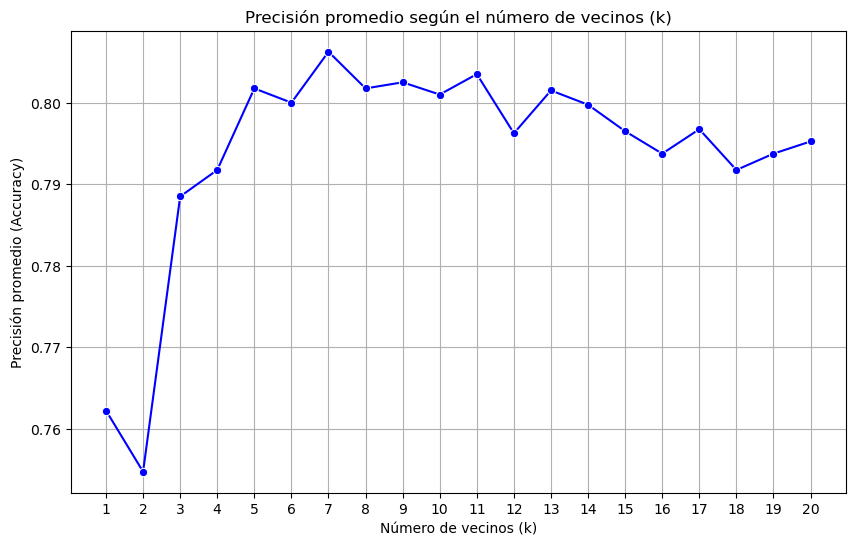

In [ ]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': list(range(1, 21))}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_projection, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print("El valor óptimo de k es: {}".format(best_k))
print("La precisión promedio óptima es: {:.2f}".format(best_score))

k_values = cv_results["param_n_neighbors"]
mean_scores = cv_results["mean_test_score"]

plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=mean_scores, marker="o", color="b")
plt.title("Precisión promedio según el número de vecinos (k)")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Precisión promedio (Accuracy)")
plt.xticks(range(1, 21))  
plt.grid()
plt.show()

Entrenando el modelo KNN con el valor óptimo de k = 7
Train accuracy (KNN, k=7): 0.84
Test accuracy (KNN, k=7): 0.79
Matriz de Confusión (KNN, k=7):


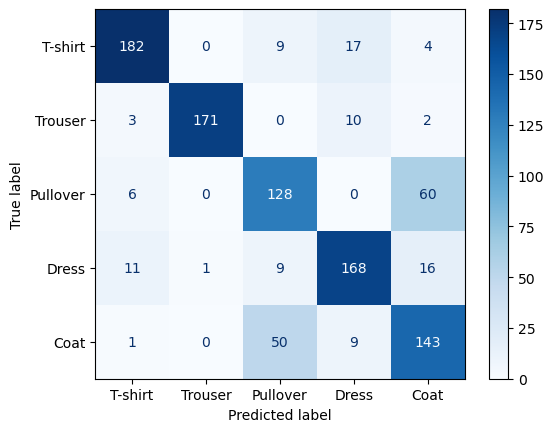

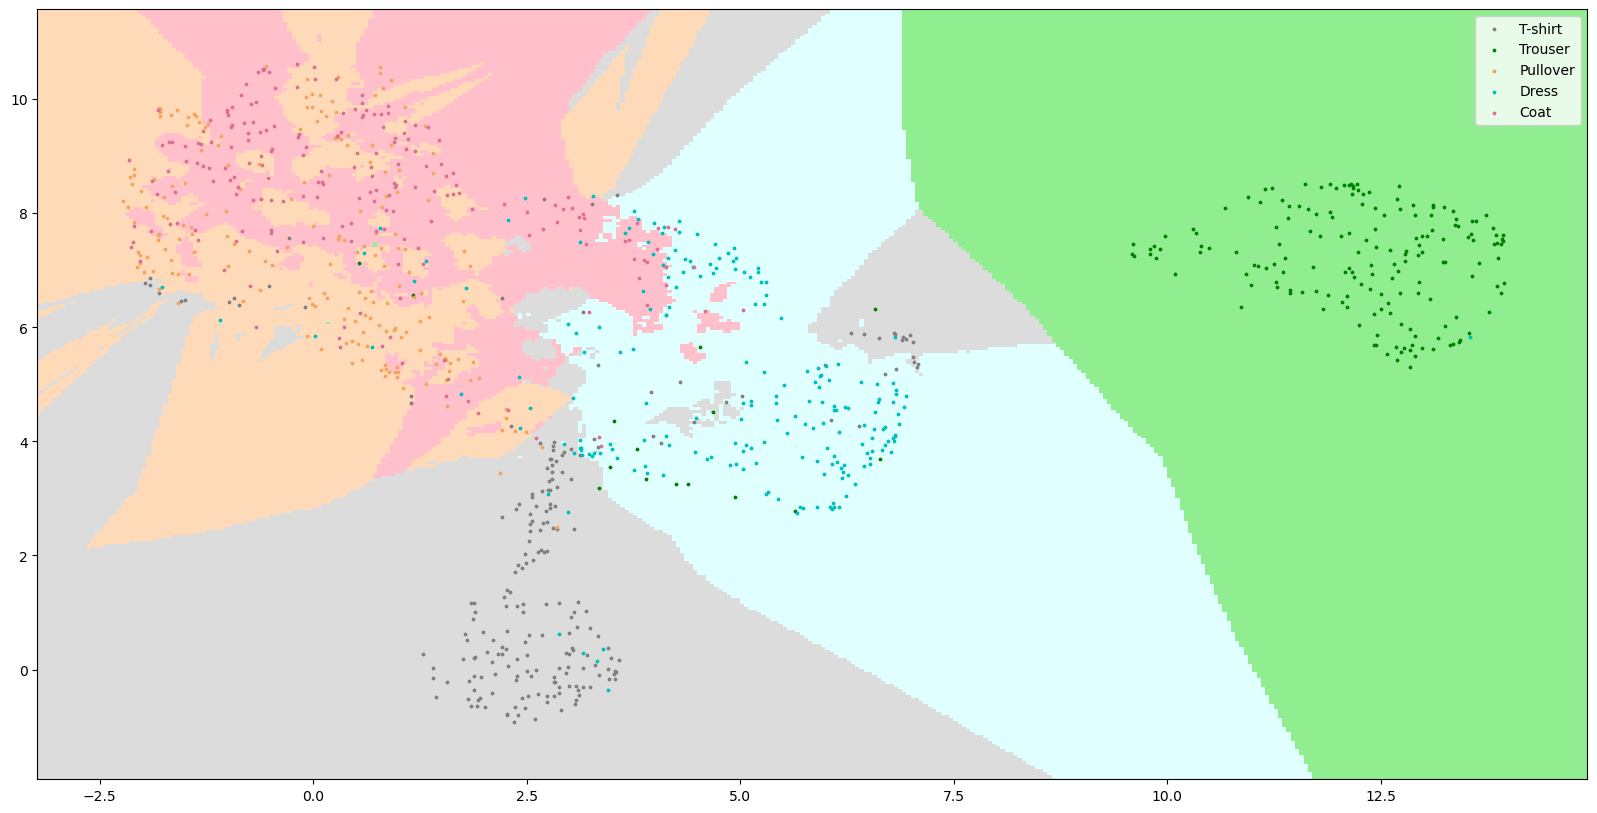

In [20]:
best_k = grid_search.best_params_['n_neighbors']
print(f"Entrenando el modelo KNN con el valor óptimo de k = {best_k}")

# 1. Entrenamiento del modelo KNN con el mejor k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_projection, y_train)

# 2. Cálculo del accuracy
y_train_pred_best = knn_best.predict(X_train_projection)
y_test_pred_best = knn_best.predict(X_test_projection)

train_accuracy_best = accuracy_score(y_train, y_train_pred_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

print("Train accuracy (KNN, k={}): {:.2f}".format(best_k, train_accuracy_best))
print("Test accuracy (KNN, k={}): {:.2f}".format(best_k, test_accuracy_best))

# 3. Matriz de confusión
cm_best = confusion_matrix(y_test, y_test_pred_best)
print("Matriz de Confusión (KNN, k={}):".format(best_k))
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels)
disp_best.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Frontera de decisión
plot_decision_boundaries(knn_best, X_test_projection, y_test)


<div class="alert alert-block alert-success">

1. Con valores pequeños de k el modelo mostró una menor precisión debido a su sensibilidad al ruido y tendencia a sobreajustar. A partir de k=7, se alcanzó la precisión máxima promedio de 0.81 en validación cruzada. Con valores de k más grandes, la precisión se estabilizó o disminuyó ligeramente, lo que indica que el modelo se vuelve más "suave" al considerar más vecinos y pierde sensibilidad a patrones locales.

2. La precisión aumenta rápidamente entre k=3 y k=7, alcanzando un pico. Posteriormente, se estabiliza o disminuye ligeramente a medida que aumenta k, lo cual es consistente con la naturaleza del algoritmo KNN: valores grandes de k generan modelos más "generalizados" pero menos sensibles a los detalles locales.

3. Las fronteras de decisión generadas por KNN son complejas y no lineales, lo cual es esperado debido a que el modelo se basa en la proximidad local a los puntos de entrenamiento. Las regiones más homogéneas, como la clase "Trouser, están bien definidas. Sin embargo, las regiones con solapamiento significativo entre clases, como "Pullover" y "Coat", muestran fronteras más complejas y menos claras.

4. El train accuracy es 0.84, mientras que la test accuracy es 0.79, lo cual indica un buen equilibrio y ausencia de sobreajuste significativo. La matriz de confusión muestra que clases como "T-shirt" y "Trouser" tienen un alto número de predicciones correctas mientras que "Pullover" y "Coat" continúan presentando errores frecuentes entre sí debido al solapamiento
</div>

<a id='ej14'></a>
## 1.5. SVM 

En esta sección, exploraremos las Máquinas de Vectores de Soporte (SVM), que se basan en el concepto del _Maximal Margin Classifier_ y el hiperplano.

Un hiperplano en un espacio p-dimensional se define como un subespacio plano y afín de dimensiones p-1. En dos dimensiones, es una recta; en tres, un plano convencional. Para dimensiones mayores a tres, aunque no es intuitivo visualizarlo, el concepto se mantiene.

Cuando los casos son perfectamente separables de manera lineal, surgen infinitos posibles hiperplanos. Para seleccionar el clasificador óptimo, utiliza el concepto de _maximal margin hyperplane_, el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Este se define calculando la distancia perpendicular mínima (margen) de las observaciones a un hiperplano. El hiperplano óptimo es aquel que maximiza este margen.

En el proceso de optimización, deberemos tener en cuenta que solo las observaciones al margen o que lo violan (vectores soporte) influyen en el hiperplano. Estos vectores soporte son los que definen el clasificador.

#### Los _kernels_ en SVM

En situaciones donde no se puede encontrar un hiperplano que separe dos clases, es decir, cuando las clases no son linealmente separables, podemos utilizar el truco del núcleo (_kernel trick_). Este método permite trabajar en una dimensión nueva donde es posible encontrar un hiperplano para separar las clases.

Al igual que con el KNN, las SVM también dependen de varios hiperparámetros. En este caso, nos enfocaremos en optimizar dos hiperparámetros:

1. **C**: la regularización, que es el valor de penalización de los errores en la clasificación. Este valor indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar correctamente el máximo número de ejemplos. Probaremos los siguientes valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
   
2. **Gamma**: un coeficiente que multiplica la distancia entre dos puntos en el kernel radial. En términos simples, cuanto más pequeño sea gamma, más influencia tendrán dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.

Para validar el rendimiento del algoritmo con cada combinación de hiperparámetros, utilizaremos la validación cruzada (_cross-validation_) con 4 particiones estratificadas."

Mejores hiperparámetros encontrados: C = 1, Gamma = 10
Precisión promedio óptima: 0.81


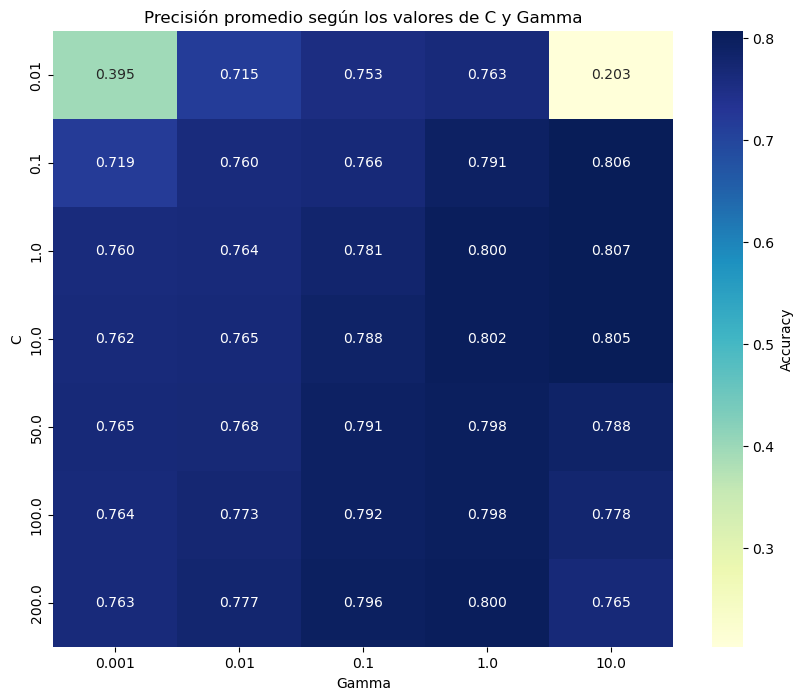

In [22]:
svm = SVC(kernel='rbf')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 200],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_projection, y_train)

svm_results = pd.DataFrame(grid_search_svm.cv_results_)

best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print("Mejores hiperparámetros encontrados: C = {}, Gamma = {}".format(best_params_svm['C'], best_params_svm['gamma']))
print("Precisión promedio óptima: {:.2f}".format(best_score_svm))

pivot_table = svm_results.pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.title("Precisión promedio según los valores de C y Gamma")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()

Train accuracy (SVM, C=1, Gamma=10): 0.84
Test accuracy (SVM, C=1, Gamma=10): 0.79
Matriz de Confusión (SVM, C=1, Gamma=10):


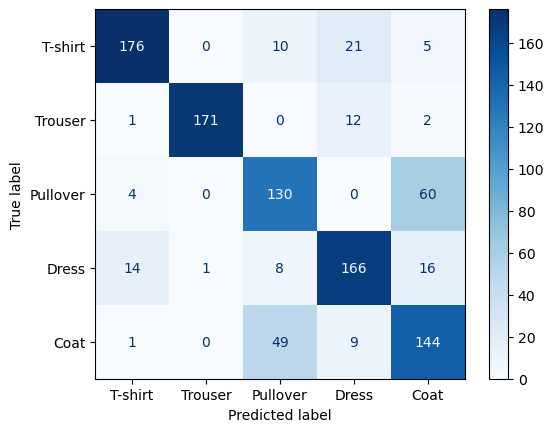

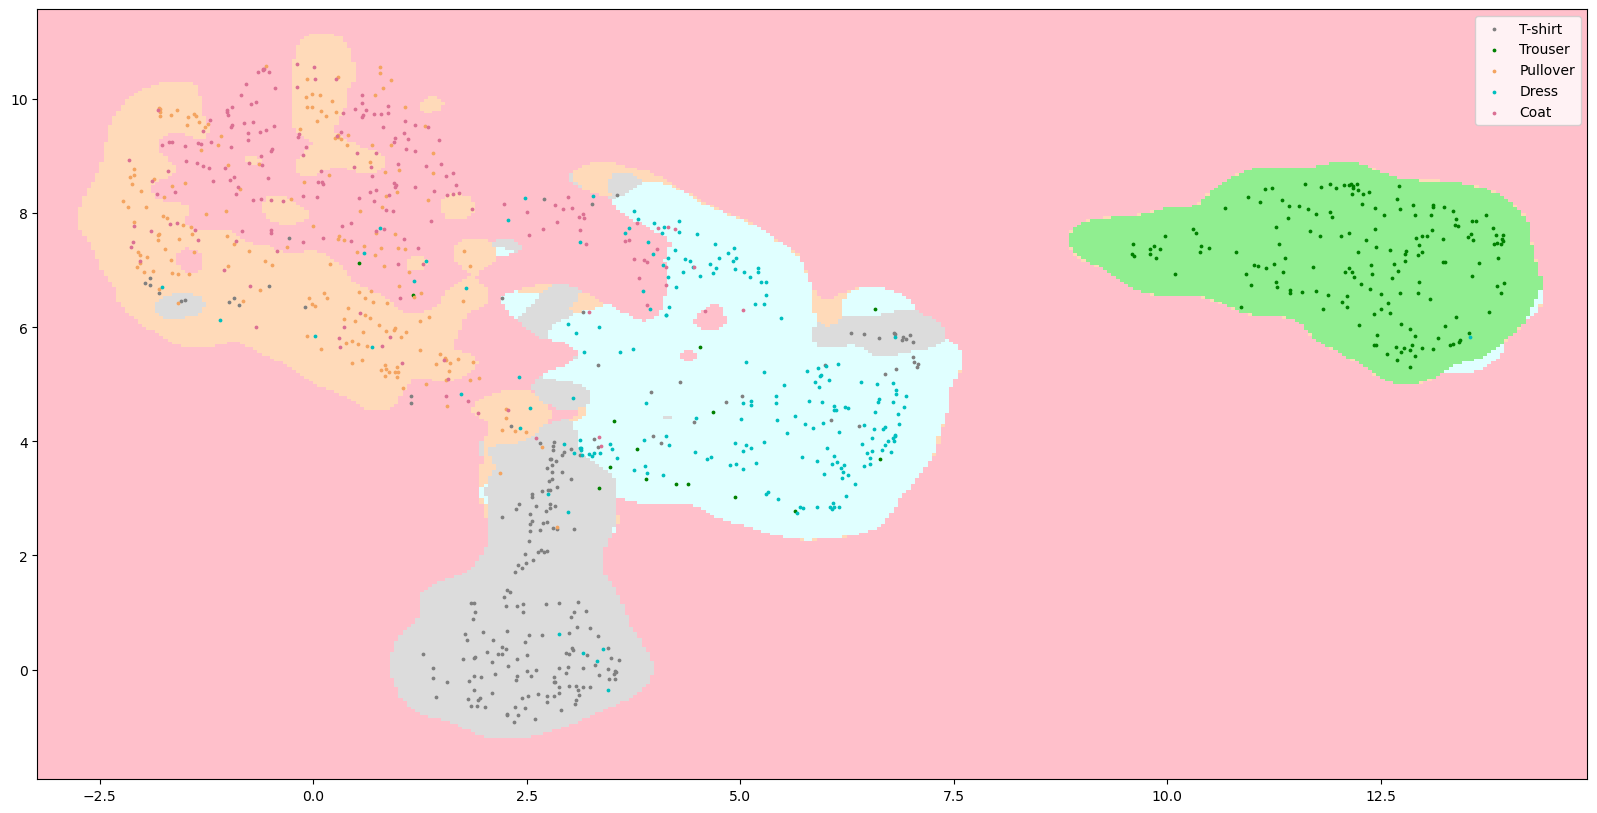

In [23]:
# 1. Entrenamiento del modelo SVM con los mejores hiperparámetros
svm_best = SVC(C=1, gamma=10, kernel='rbf')
svm_best.fit(X_train_projection, y_train)

# 2. Cálculo del accuracy
y_train_pred_svm = svm_best.predict(X_train_projection)
y_test_pred_svm = svm_best.predict(X_test_projection)

train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

print("Train accuracy (SVM, C=1, Gamma=10): {:.2f}".format(train_accuracy_svm))
print("Test accuracy (SVM, C=1, Gamma=10): {:.2f}".format(test_accuracy_svm))

# 3. Matriz de confusión
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
print("Matriz de Confusión (SVM, C=1, Gamma=10):")
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp_svm.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Representación de las fronteras de decisión
plot_decision_boundaries(svm_best, X_test_projection, y_test)

<div class="alert alert-block alert-success">

1. En la búsqueda de rejilla, los valores óptimos encontrados fueron C = 1 y Gamma = 10, con una precisión promedio de 0.81 en validación cruzada. Un valor alto de Gamma = 10 hace que el modelo sea más sensible a las distancias entre puntos cercanos, generando fronteras más complejas. Esto tiene sentido en este contexto, dado que las clases presentan solapamiento.

2. Las fronteras de decisión son no lineales y complejas, lo cual es coherente con el kernel radial (RBF) utilizado en el modelo SVM. Las regiones de las clases, como "Trouser", "T-Shirt" y "Dress", están bien separadas y definidas. Sin embargo, las clases "Pullover" y "Coat" muestran un solapamiento significativo. Las fronteras reflejan cómo el valor alto de Gamma permite que el modelo se adapte localmente a los datos, generando regiones más ajustadas y sensibles.

3. Las clases "T-shirt" y "Trouser" tienen altos aciertos con pocas confusiones, lo cual indica que el modelo distingue bien estas clases.
La clase "Pullover" continúa mostrando confusiones con "Coat", pero ha mejorado su rendidimiento notablemente en comparacion con los otros modelos.


</div>

<a id='ej15'></a>
## 1.6. Árboles de decisión 

En esta sección, vamos a explorar los árboles de decisión, modelos predictivos que se basan en reglas binarias (si/no) para clasificar las observaciones según sus atributos y predecir el valor de la variable respuesta. Estos árboles pueden ser clasificadores o regresores para predecir variables continuas.

#### Construcción de un Árbol

Para construir un árbol, seguiremos el algoritmo de *recursive binary splitting*:

1. Comienza en la parte superior del árbol, donde todas las observaciones pertenecen a la misma región.
2. Identifica todos los posibles puntos de corte para cada uno de los predictores. Estos puntos de corte son los diferentes niveles de los predictores.
3. Evalúa las posibles divisiones para cada predictor utilizando una medida específica. En los clasificadores, estas medidas pueden ser el *classification error rate*, el índice Gini, la entropía o el chi-square.



Train accuracy (Decision Tree): 1.00
Test accuracy (Decision Tree): 0.74
Matriz de Confusión (Decision Tree):


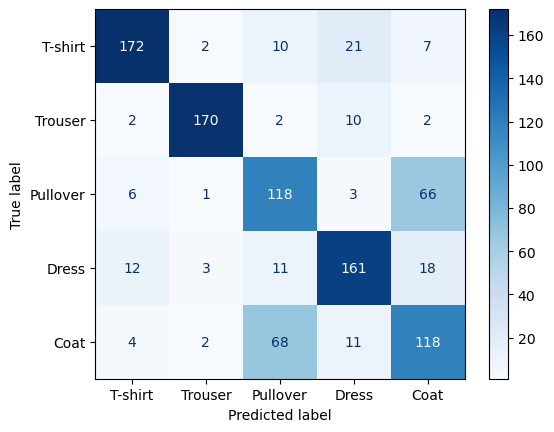

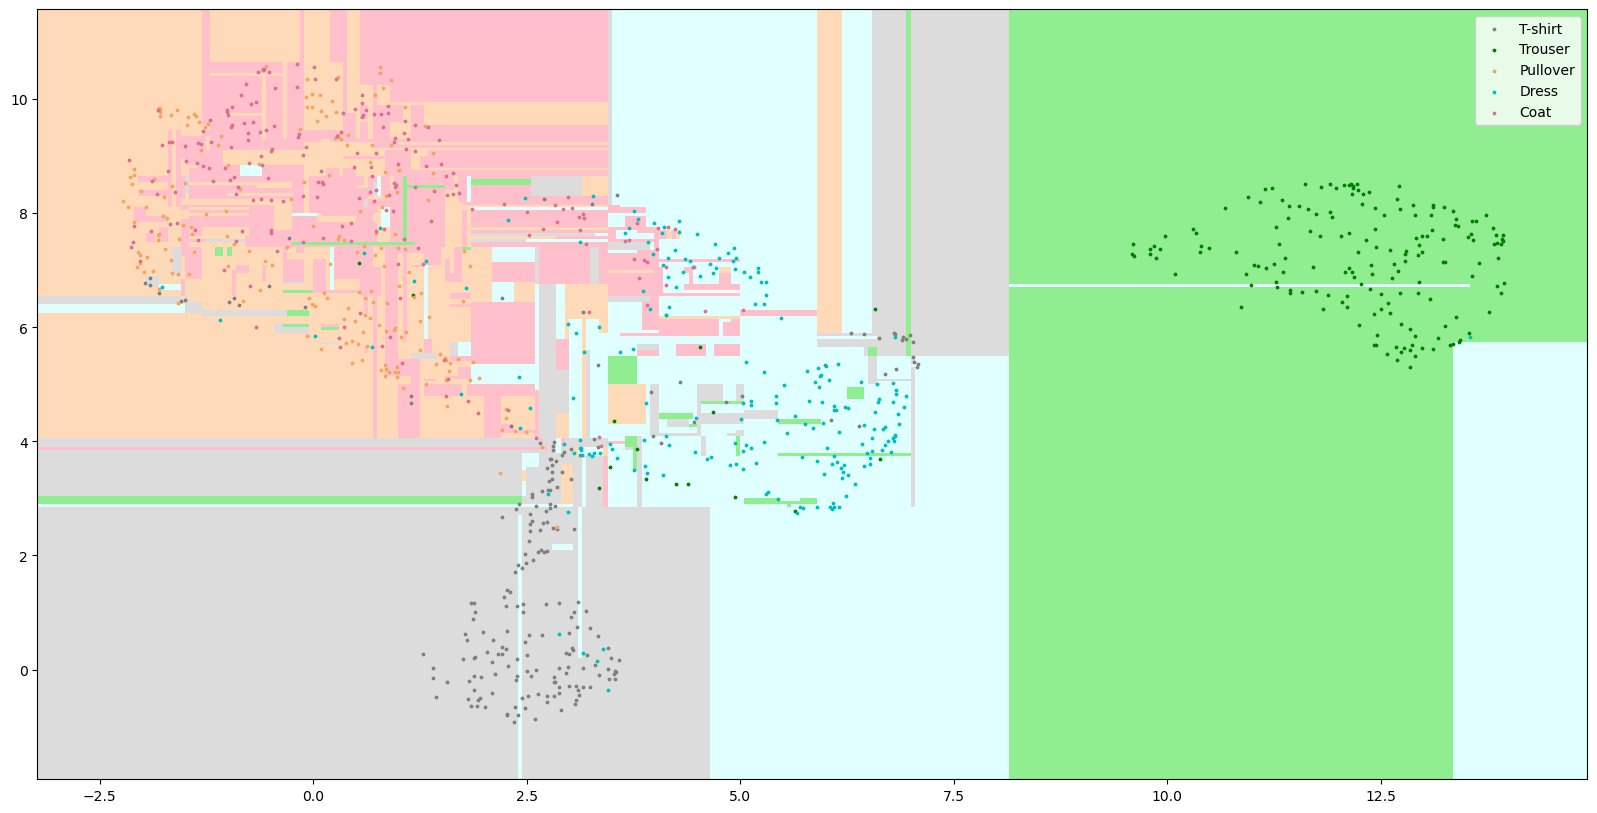

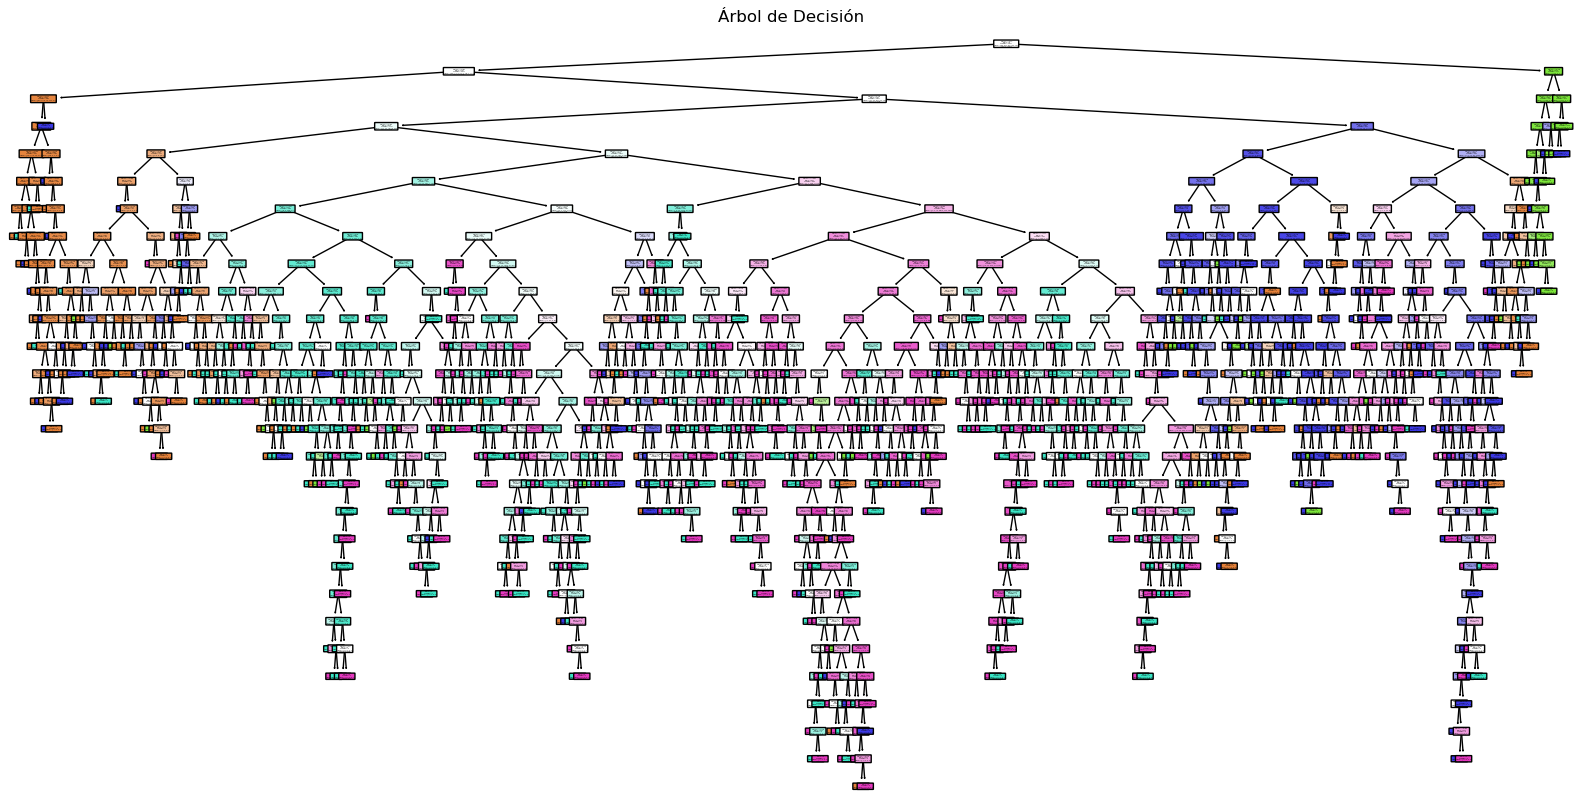

In [26]:
# 1. Entrenamiento del Árbol de Decisión
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_projection, y_train)

# 2. Cálculo del accuracy
y_train_pred_tree = tree_clf.predict(X_train_projection)
y_test_pred_tree = tree_clf.predict(X_test_projection)
train_accuracy_tree = accuracy_score(y_train, y_train_pred_tree)
test_accuracy_tree = accuracy_score(y_test, y_test_pred_tree)

print("Train accuracy (Decision Tree): {:.2f}".format(train_accuracy_tree))
print("Test accuracy (Decision Tree): {:.2f}".format(test_accuracy_tree))

# 3. Matriz de confusión
cm_tree = confusion_matrix(y_test, y_test_pred_tree)
print("Matriz de Confusión (Decision Tree):")
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=labels)
disp_tree.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Representación de las fronteras de decisión
plot_decision_boundaries(tree_clf, X_test_projection, y_test)

# 5. Representación gráfica del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=["UMAP1", "UMAP2"], class_names=labels, filled=True, rounded=True)
plt.title("Árbol de Decisión")
plt.show()


<div class="alert alert-block alert-success">

1. El árbol de decisión ha logrado una precisión perfecta en el conjunto de entrenamiento. Esto es una señal clara de sobreajuste, lo podemos confirmar al revisar la precisión en el conjunto de prueba, el cual es significativamente más baja, lo que confirma que el modelo no generaliza bien a nuevos datos. La matriz muestra que las clases "Pullover" y "Coat" siguen siendo las más problemáticas, con un número considerable de errores.

2. La frontera de decisión es altamente segmentada y compleja, con muchas divisiones rectangulares pequeñas. Esto es una característica típica de los árboles de decisión cuando sobreajustan los datos donde cada rectángulo representa una regla específica generada para clasificar los datos. La sobrecarga de divisiones es el resultado del ajuste excesivo a los puntos de entrenamiento. En regiones donde las clases están muy solapadas (como "Pullover" y "Coat"), el árbol intenta crear múltiples divisiones para acomodar los errores, pero esto no generaliza bien en el conjunto de prueba.

3. La representación gráfica del árbol muestra una profundidad considerable con un alto número de divisiones. El árbol ha creado muchas ramificaciones y reglas para ajustar los datos de entrenamiento, lo que explica el sobreajuste. La complejidad del árbol hace difícil interpretarlo.

</div>

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*.
   
Para evitar el *overfitting* en los árboles de decisión, es crucial que modifiques ciertos hiperparámetros del modelo de la siguiente manera:

1. Utilizaremos el hiperparámetro `max_depth`, que define la profundidad máxima del árbol. Deberás explorar los valores entre 4 y 10 para encontrar el equilibrio adecuado entre la complejidad del modelo y su capacidad para generalizar.
2. Estableceremos el hiperparámetro `min_samples_split`, que es el número mínimo de observaciones que debe tener una hoja del árbol antes de considerar una división. Experimentaremos con valores como 2, 10, 20, 50 y 100 para asegurarte de que el árbol no se vuelva demasiado específico para las observaciones de entrenamiento.

Ajustando estos hiperparámetros, podremos controlar la tendencia del árbol de decisión a sobreajustarse al conjunto de entrenamiento, mejorando así su capacidad para realizar predicciones efectivas en nuevos datos."

Mejores hiperparámetros encontrados: max_depth = 10, min_samples_split = 100
Precisión promedio óptima: 0.79


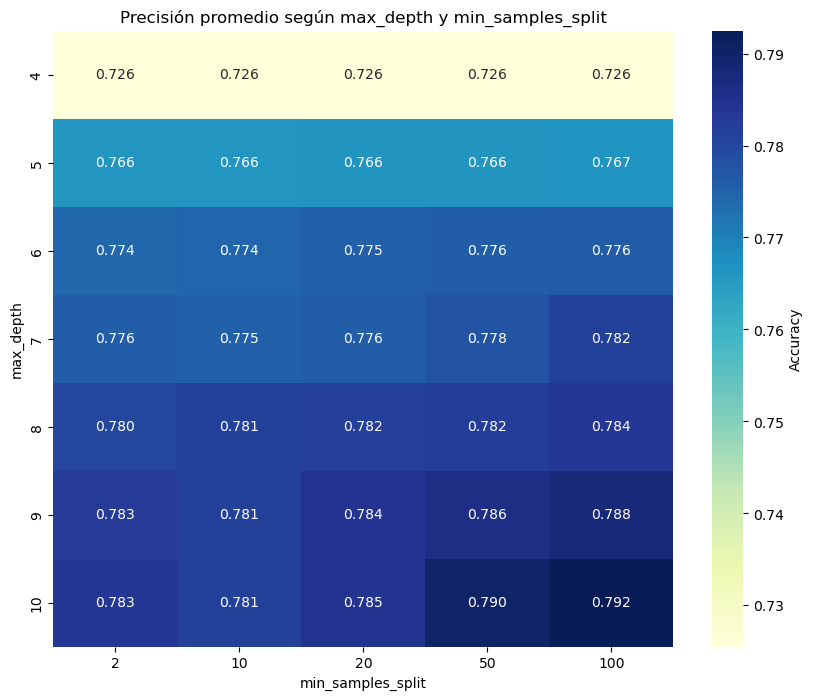

In [27]:
tree_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': range(4, 11),  
    'min_samples_split': [2, 10, 20, 50, 100]  
}

grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid, 
                                cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train_projection, y_train)

tree_results = pd.DataFrame(grid_search_tree.cv_results_)

best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_
print("Mejores hiperparámetros encontrados: max_depth = {}, min_samples_split = {}".format(
    best_params_tree['max_depth'], best_params_tree['min_samples_split']))
print("Precisión promedio óptima: {:.2f}".format(best_score_tree))

pivot_table = tree_results.pivot_table(index='param_max_depth', 
                                       columns='param_min_samples_split', 
                                       values='mean_test_score')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.title("Precisión promedio según max_depth y min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()

Train accuracy (Optimized Decision Tree): 0.82
Test accuracy (Optimized Decision Tree): 0.78
Matriz de Confusión (Optimized Decision Tree):


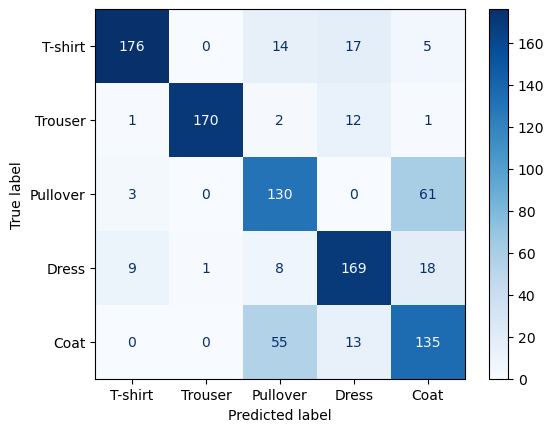

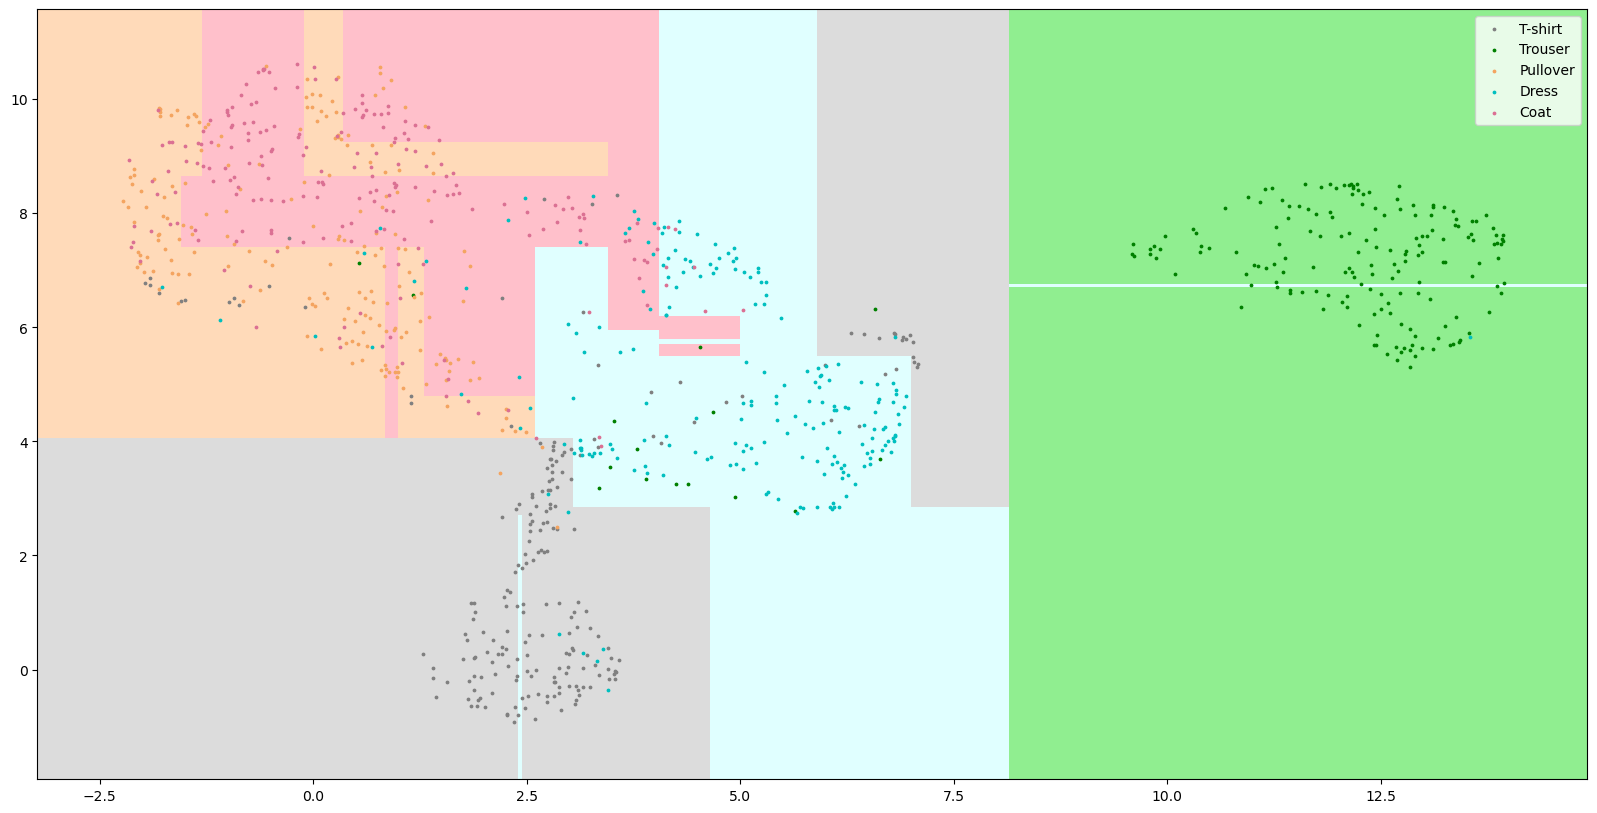

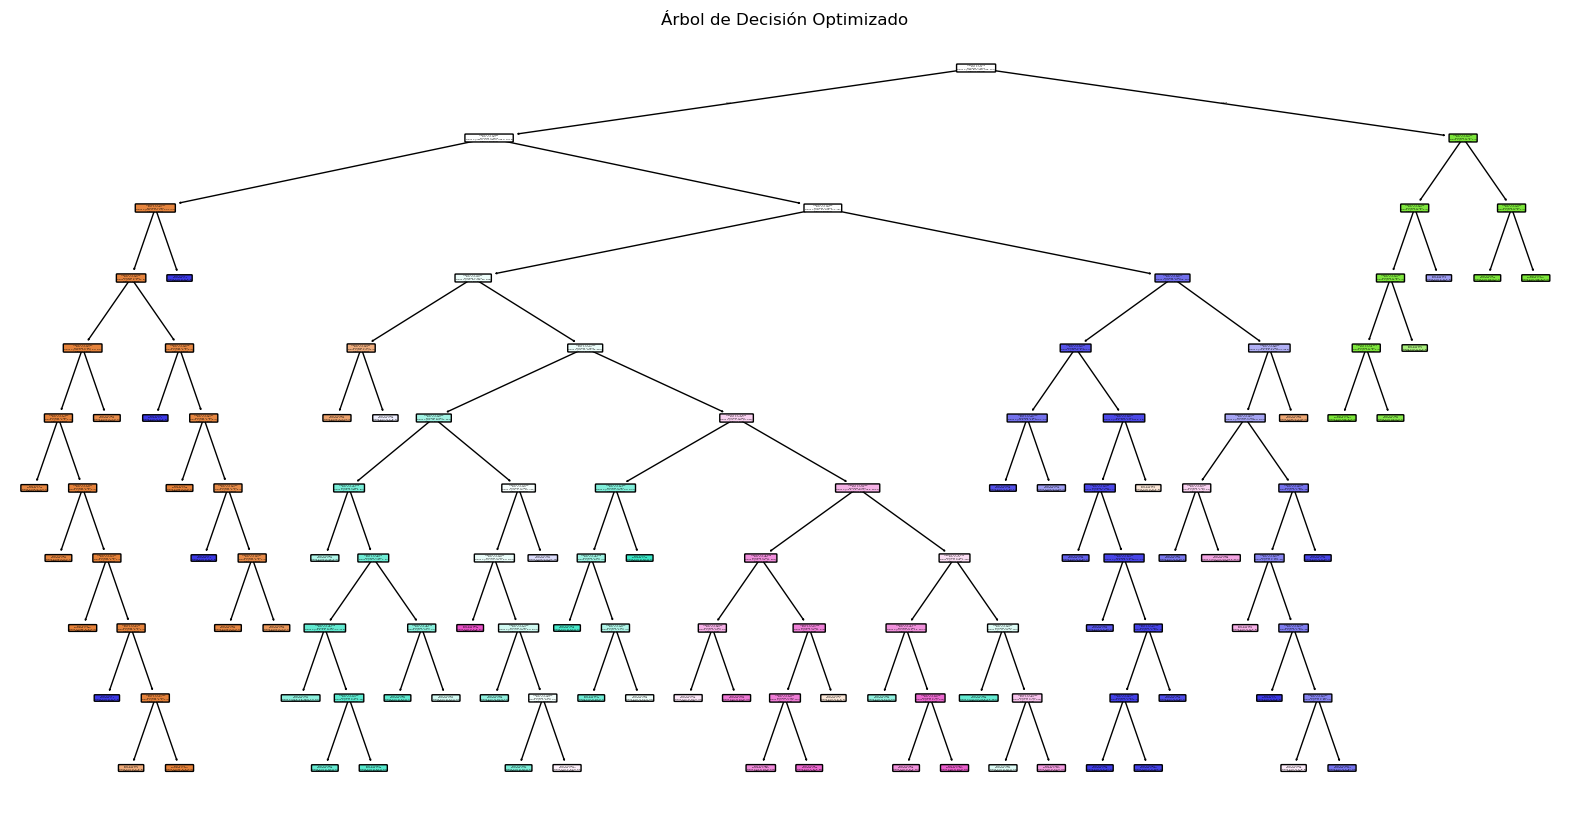

In [28]:
# 1. Entrenamiento del Árbol de Decisión con hiperparámetros óptimos
tree_clf_best = DecisionTreeClassifier(max_depth=10, min_samples_split=100, random_state=42)
tree_clf_best.fit(X_train_projection, y_train)

# 2. Cálculo del accuracy
y_train_pred_best = tree_clf_best.predict(X_train_projection)
y_test_pred_best = tree_clf_best.predict(X_test_projection)
train_accuracy_best = accuracy_score(y_train, y_train_pred_best)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

print("Train accuracy (Optimized Decision Tree): {:.2f}".format(train_accuracy_best))
print("Test accuracy (Optimized Decision Tree): {:.2f}".format(test_accuracy_best))

# 3. Matriz de Confusión
cm_best = confusion_matrix(y_test, y_test_pred_best)
print("Matriz de Confusión (Optimized Decision Tree):")
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels)
disp_best.plot(cmap='Blues', values_format='d')
plt.show()

# 4. Frontera de decisión
plot_decision_boundaries(tree_clf_best, X_test_projection, y_test)

# 5. Representación gráfica del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(tree_clf_best, feature_names=["UMAP1", "UMAP2"], class_names=labels, filled=True, rounded=True)
plt.title("Árbol de Decisión Optimizado")
plt.show()


<div class="alert alert-block alert-success">

1. La precisión en el conjunto de entrenamiento ha bajado de 1.00 (anteriormente) a 0.82. Esto indica que el árbol ha logrado reducir el sobreajuste. La precisión en el conjunto de prueba ha mejorado en comparación con el modelo anterior

2. Las fronteras de decisión son ahora más simples y generalizadas. A diferencia el árbol anteior, las fronteras muestran regiones más amplias y menos fragmentadas. Esto es coherente con la configuración de max_depth y min_samples_split, que limita la complejidad del modelo. Las regiones como la clase "Trouser" están bien definidas, mientras que las clases "Pullover" y "Coat" todavía presentan solapamiento.

3. La matriz de confusión muestra una reducción en los errores en comparación con el árbol inicial. "Pullover" y "Coat" siguen siendo las clases más problemáticas, aunque los errores han disminuido. El árbol optimizado tiene una profundidad más controlada y un número reducido de ramificaciones, esto lo hace más interpretable y evita las divisiones excesivas observadas en el árbol inicial.

</div>